In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn

import sklearn.datasets

import matplotlib.pyplot as plt

from utils.data.helpers import rotate
from utils.model.models import MLP
from utils.visualization.visualize import plot_decision_boundary

from pathlib import Path

import csv
from tqdm.notebook import tqdm

In [4]:
# Dataset
X,y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=42)

# Normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

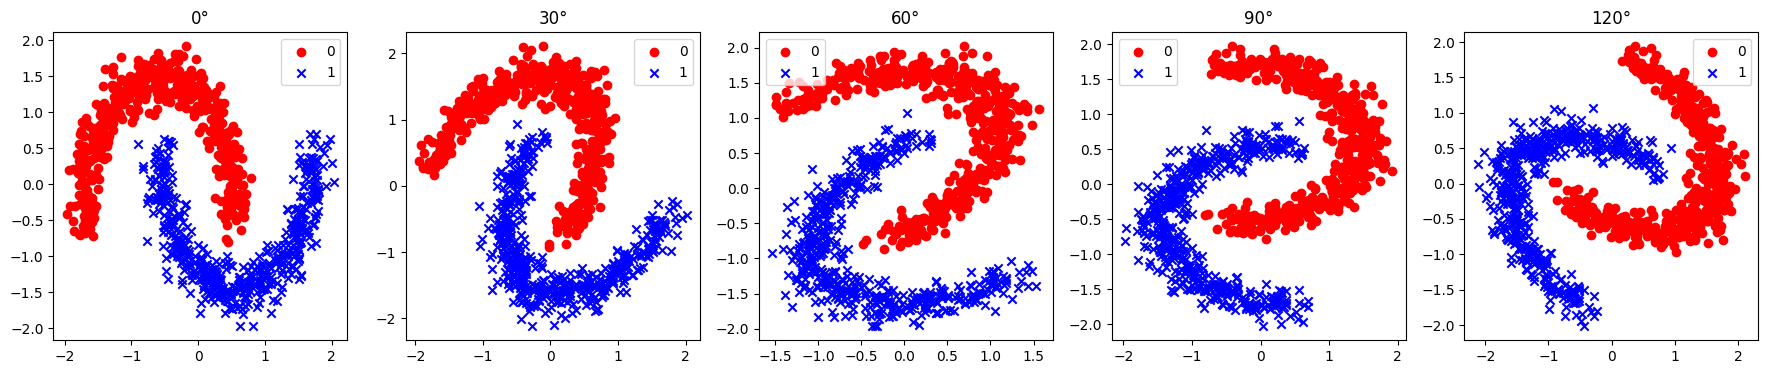

In [5]:
# Vizualization of different rotations
angles = [0, 30, 60, 90, 120]

fig, ax = plt.subplots(1, 5, figsize=(22, 4))

for i, angle in enumerate(angles):
    X_rotated = rotate(X, angle)
    ax[i].scatter(X_rotated[y==0,0], X_rotated[y==0,1], color='red', marker='o')
    ax[i].scatter(X_rotated[y==1,0], X_rotated[y==1,1], color='blue', marker='x')
    ax[i].legend(["0","1"])
    ax[i].set_title(f"{angle}°")

plt.show()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
zoo_name = "four_angles"
save_dir = Path("../models") / zoo_name
angles = [0, 90, 180, 270]
models_per_angle = 2000
epochs = 60

# Dataset
X,y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=42)

# Normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [26]:
# Train a model zoo

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

zoo_name = "four_angles"
save_dir = Path("../models") / zoo_name
angles = [0, 90, 180, 270]
models_per_angle = 2000
epochs = 60

torch.manual_seed(42)
model_accuracies = []

for angle in tqdm(angles):
    X_rotated = rotate(X, angle)
    X_tensor = torch.tensor(X_rotated, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    for i in range(models_per_angle):
        model = MLP(input_dim=2, hidden_dims=[10, 10], output_dim=1)
        model.to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(X_tensor).flatten()
            loss = criterion(y_pred, y_tensor)
            loss.backward()
            optimizer.step()
        
        model.eval()
        y_pred = model(X_tensor).flatten()
        correct = (y_pred.round() == y_tensor).sum().item()
        accuracy = correct / len(y)

        model_name = f"model_{angle}_{i}.pth"
        torch.save(model.state_dict(), save_dir/model_name)
        model_accuracies.append((model_name, accuracy))

with open(f"../reports/{zoo_name}.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["model_name", "accuracy"])
    writer.writerows(model_accuracies)


  0%|          | 0/4 [00:00<?, ?it/s]

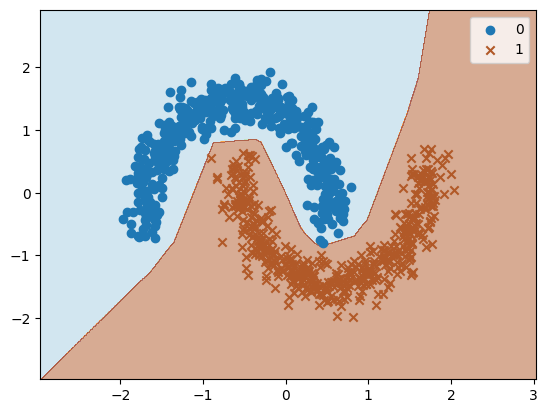

In [33]:
# Plot the decision boundary of the model

model.load_state_dict(torch.load("../models/four_angles/model_0_0.pth"))

plot_decision_boundary(model, X, y)

In [8]:
# Train a model zoo

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Zoo config
zoo_name = "eight_angles"
save_dir = Path("../models") / zoo_name
angles = [0, 45, 90, 135, 180, 225, 270, 315]
models_per_angle = 10000
epochs = 60
learning_rate = 0.05

# Model config
input_dim = 2
hidden_dims = [10, 10]
output_dim = 1

seed = 42

# Logging
torch.manual_seed(seed)
model_accuracies = []

for angle in tqdm(angles):
    X_rotated = rotate(X, angle)
    X_tensor = torch.tensor(X_rotated, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    i = 0
    while i < models_per_angle:
        model = MLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim)
        model.to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(X_tensor).flatten()
            loss = criterion(y_pred, y_tensor)
            loss.backward()
            optimizer.step()
        
        model.eval()
        y_pred = model(X_tensor).flatten()
        correct = (y_pred.round() == y_tensor).sum().item()
        accuracy = correct / len(y)
        
        if(accuracy >= 0.95):
            model_name = f"model_{angle}_{i}.pth"
            torch.save(model.state_dict(), save_dir/model_name)
            model_accuracies.append((model_name, accuracy))
            i += 1


with open(f"../reports/{zoo_name}.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["model_name", "accuracy"])
    writer.writerows(model_accuracies)


  0%|          | 0/8 [00:00<?, ?it/s]

In [9]:
from utils.data.make_datasets import zoo_to_csv

zoo_name = "eight_angles"
zoo_path = Path("../models/")/zoo_name
zoo_to_csv(zoo_path, f"../data/{zoo_name}.csv")

100%|██████████| 80000/80000 [12:21<00:00, 107.89it/s]


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

data = pd.read_csv("../data/eight_angles.csv")
data_0 = data[data["angle"] == 0]
data_0 = data_0.drop(columns=["angle", "model_name"]).values
data_45 = data[data["angle"] == 45]
data_45 = data_45.drop(columns=["angle", "model_name"]).values
data_90 = data[data["angle"] == 90]
data_90 = data_90.drop(columns=["angle", "model_name"]).values
data_135 = data[data["angle"] == 135]
data_135 = data_135.drop(columns=["angle", "model_name"]).values
data_180 = data[data["angle"] == 180]
data_180 = data_180.drop(columns=["angle", "model_name"]).values
data_225 = data[data["angle"] == 225]
data_225 = data_225.drop(columns=["angle", "model_name"]).values
data_270 = data[data["angle"] == 270]
data_270 = data_270.drop(columns=["angle", "model_name"]).values
data_315 = data[data["angle"] == 315]
data_315 = data_315.drop(columns=["angle", "model_name"]).values
diff_0_45 = np.zeros((151))
diff_0_90 = np.zeros((151))
diff_0_135 = np.zeros((151))
diff_0_180 = np.zeros((151))
diff_0_225 = np.zeros((151))
diff_0_270 = np.zeros((151))
diff_0_315 = np.zeros((151))


for i in tqdm(range(len(data_0))):
    for j in range(len(data_45)):
        diff_0_45 += np.abs(data_0[i] - data_45[j])

for i in tqdm(range(len(data_0))):
    for j in range(len(data_90)):
        diff_0_90 += np.abs(data_0[i] - data_90[j])

for i in tqdm(range(len(data_0))):
    for j in range(len(data_135)):
        diff_0_135 += np.abs(data_0[i] - data_135[j])

for i in tqdm(range(len(data_0))):
    for j in range(len(data_180 )):
        diff_0_180 += np.abs(data_0[i] - data_180[j])

for i in tqdm(range(len(data_0))):
    for j in range(len(data_225)):
        diff_0_225 += np.abs(data_0[i] - data_225[j])

for i in tqdm(range(len(data_0))):
    for j in range(len(data_270)):
        diff_0_270 += np.abs(data_0[i] - data_270[j])

for i in tqdm(range(len(data_0))):
    for j in range(len(data_315)):
        diff_0_315 += np.abs(data_0[i] - data_315[j])

diff_0_45 = diff_0_45 / diff_0_45.max()
diff_0_90 = diff_0_90 / diff_0_90.max()
diff_0_135 = diff_0_135 / diff_0_135.max()
diff_0_180 = diff_0_180 / diff_0_180.max()
diff_0_225 = diff_0_225 / diff_0_225.max()
diff_0_270 = diff_0_270 / diff_0_270.max()
diff_0_315 = diff_0_315 / diff_0_315.max()

mask_0_45 = diff_0_45 > 0.9
mask_0_90 = diff_0_90 > 0.9
mask_0_135 = diff_0_135 > 0.9
mask_0_180 = diff_0_180 > 0.9
mask_0_225 = diff_0_225 > 0.9
mask_0_270 = diff_0_270 > 0.9
mask_0_315 = diff_0_315 > 0.9

print("Difference between 0 and 45:")
print(mask_0_45)
print("\n\n")

print("Difference between 0 and 90:")
print(mask_0_90)
print("\n\n")

print("Difference between 0 and 135:")
print(mask_0_135)
print("\n\n")

print("Difference between 0 and 180:")
print(mask_0_180)
print("\n\n")

print("Difference between 0 and 225:")
print(mask_0_225)
print("\n\n")

print("Difference between 0 and 270:")
print(mask_0_270)
print("\n\n")

print("Difference between 0 and 315:")
print(mask_0_315)
print("\n\n")

100%|██████████| 10000/10000 [03:49<00:00, 43.65it/s]

Difference between 0 and 45:
[ True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]



Difference between 0 and 90:
[ True  True  True 

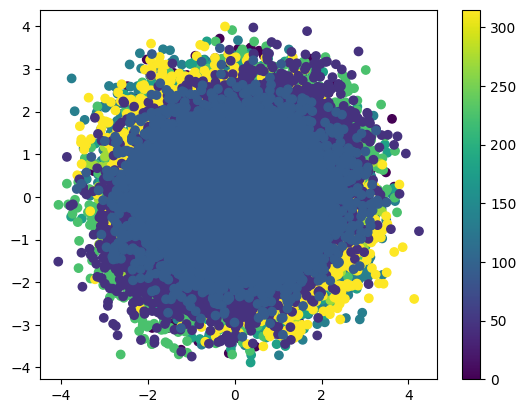

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

df = pd.read_csv("../data/eight_angles.csv")
weights = df.drop(columns=["model_name", "angle"])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(weights)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['angle'])
plt.colorbar()
plt.show()

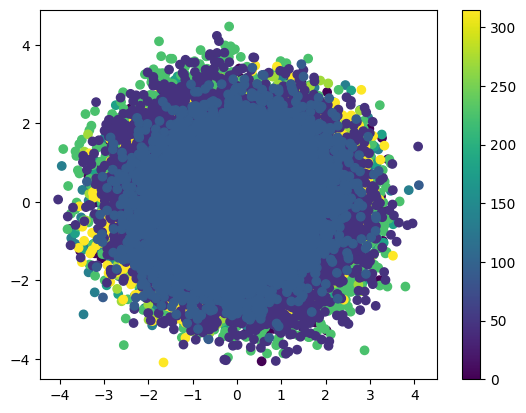

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

df = pd.read_csv("../data/eight_angles.csv")
weights = df[["weight_0", "weight_1", "weight_2", "weight_3", "weight_4", "weight_5", "weight_6", "weight_7", "weight_8", "weight_9", "weight_10", "weight_11", "weight_12", "weight_13", "weight_14", "weight_15", "weight_16", "weight_17", "weight_18", "weight_19", "weight_20", "weight_21", "weight_22", "weight_23", "weight_24", "weight_25", "weight_26", "weight_27", "weight_28", "weight_29", "weight_140", "weight_141", "weight_142", "weight_143", "weight_144", "weight_145", "weight_146", "weight_147", "weight_148", "weight_149", "weight_150"]]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(weights)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['angle'])
plt.colorbar()
plt.show()

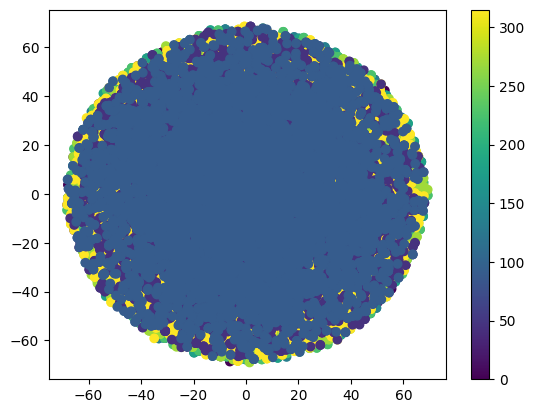

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

df = pd.read_csv("../data/eight_angles.csv")
weights = df.drop(columns=["model_name", "angle"])
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(weights)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df['angle'])
plt.colorbar()
plt.show()

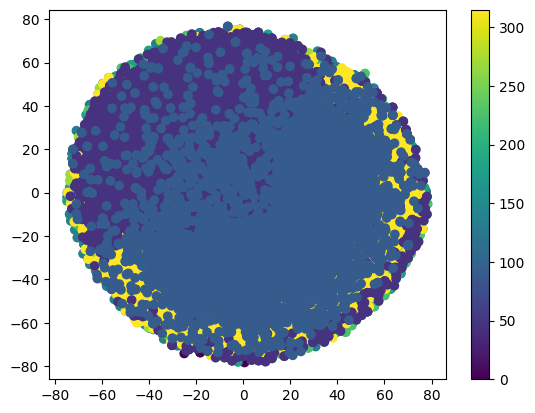

In [9]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

df = pd.read_csv("../data/eight_angles.csv")
weights = df[["weight_0", "weight_1", "weight_2", "weight_3", "weight_4", "weight_5", "weight_6", "weight_7", "weight_8", "weight_9", "weight_10", "weight_11", "weight_12", "weight_13", "weight_14", "weight_15", "weight_16", "weight_17", "weight_18", "weight_19", "weight_20", "weight_21", "weight_22", "weight_23", "weight_24", "weight_25", "weight_26", "weight_27", "weight_28", "weight_29", "weight_140", "weight_141", "weight_142", "weight_143", "weight_144", "weight_145", "weight_146", "weight_147", "weight_148", "weight_149", "weight_150"]]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(weights)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df['angle'])
plt.colorbar()
plt.show()

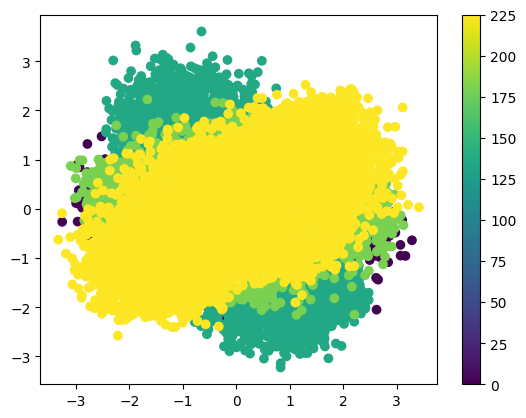

In [50]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

df = pd.read_csv("../data/eight_angles.csv")
weights = df.drop(columns=["model_name", "angle"])
weights = weights.iloc[:40000, 2:4].to_numpy()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(weights)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['angle'].iloc[:40000])
plt.colorbar()
plt.show()

In [6]:
# Important weights

import pandas as pd
data = pd.read_csv("../data/eight_angles.csv")
weights_to_drop = []
for i in range(30, 140):
    weights_to_drop.append(f"weight_{i}")
print(weights_to_drop)
data = data.drop(columns=weights_to_drop)
data.to_csv("../data/eight_angles_small.csv", index=False)

['weight_30', 'weight_31', 'weight_32', 'weight_33', 'weight_34', 'weight_35', 'weight_36', 'weight_37', 'weight_38', 'weight_39', 'weight_40', 'weight_41', 'weight_42', 'weight_43', 'weight_44', 'weight_45', 'weight_46', 'weight_47', 'weight_48', 'weight_49', 'weight_50', 'weight_51', 'weight_52', 'weight_53', 'weight_54', 'weight_55', 'weight_56', 'weight_57', 'weight_58', 'weight_59', 'weight_60', 'weight_61', 'weight_62', 'weight_63', 'weight_64', 'weight_65', 'weight_66', 'weight_67', 'weight_68', 'weight_69', 'weight_70', 'weight_71', 'weight_72', 'weight_73', 'weight_74', 'weight_75', 'weight_76', 'weight_77', 'weight_78', 'weight_79', 'weight_80', 'weight_81', 'weight_82', 'weight_83', 'weight_84', 'weight_85', 'weight_86', 'weight_87', 'weight_88', 'weight_89', 'weight_90', 'weight_91', 'weight_92', 'weight_93', 'weight_94', 'weight_95', 'weight_96', 'weight_97', 'weight_98', 'weight_99', 'weight_100', 'weight_101', 'weight_102', 'weight_103', 'weight_104', 'weight_105', 'weig

In [12]:
import pandas as pd
data = pd.read_csv("../data/eight_angles.csv")
columns_to_leave = []
for i in range(30, 140):
   columns_to_leave.append(f"weight_{i}")

columns_to_leave.insert(0, "model_name")
columns_to_leave.append("angle")
print(columns_to_leave)
data = data[columns_to_leave]
data.to_csv("../data/eight_angles_middle.csv", index=False)

['model_name', 'weight_30', 'weight_31', 'weight_32', 'weight_33', 'weight_34', 'weight_35', 'weight_36', 'weight_37', 'weight_38', 'weight_39', 'weight_40', 'weight_41', 'weight_42', 'weight_43', 'weight_44', 'weight_45', 'weight_46', 'weight_47', 'weight_48', 'weight_49', 'weight_50', 'weight_51', 'weight_52', 'weight_53', 'weight_54', 'weight_55', 'weight_56', 'weight_57', 'weight_58', 'weight_59', 'weight_60', 'weight_61', 'weight_62', 'weight_63', 'weight_64', 'weight_65', 'weight_66', 'weight_67', 'weight_68', 'weight_69', 'weight_70', 'weight_71', 'weight_72', 'weight_73', 'weight_74', 'weight_75', 'weight_76', 'weight_77', 'weight_78', 'weight_79', 'weight_80', 'weight_81', 'weight_82', 'weight_83', 'weight_84', 'weight_85', 'weight_86', 'weight_87', 'weight_88', 'weight_89', 'weight_90', 'weight_91', 'weight_92', 'weight_93', 'weight_94', 'weight_95', 'weight_96', 'weight_97', 'weight_98', 'weight_99', 'weight_100', 'weight_101', 'weight_102', 'weight_103', 'weight_104', 'weig

In [11]:
import pandas as pd
data = pd.read_csv("../data/eight_angles.csv")
columns_to_leave = []
for i in range(0, 60):
   columns_to_leave.append(f"weight_{i}")

for i in range(140, 151):
   columns_to_leave.append(f"weight_{i}")

columns_to_leave.insert(0, "model_name")
columns_to_leave.append("angle")
print(columns_to_leave)
data = data[columns_to_leave]
data.to_csv("../data/eight_angles_1.csv", index=False)

['model_name', 'weight_0', 'weight_1', 'weight_2', 'weight_3', 'weight_4', 'weight_5', 'weight_6', 'weight_7', 'weight_8', 'weight_9', 'weight_10', 'weight_11', 'weight_12', 'weight_13', 'weight_14', 'weight_15', 'weight_16', 'weight_17', 'weight_18', 'weight_19', 'weight_20', 'weight_21', 'weight_22', 'weight_23', 'weight_24', 'weight_25', 'weight_26', 'weight_27', 'weight_28', 'weight_29', 'weight_30', 'weight_31', 'weight_32', 'weight_33', 'weight_34', 'weight_35', 'weight_36', 'weight_37', 'weight_38', 'weight_39', 'weight_40', 'weight_41', 'weight_42', 'weight_43', 'weight_44', 'weight_45', 'weight_46', 'weight_47', 'weight_48', 'weight_49', 'weight_50', 'weight_51', 'weight_52', 'weight_53', 'weight_54', 'weight_55', 'weight_56', 'weight_57', 'weight_58', 'weight_59', 'weight_140', 'weight_141', 'weight_142', 'weight_143', 'weight_144', 'weight_145', 'weight_146', 'weight_147', 'weight_148', 'weight_149', 'weight_150', 'angle']


In [32]:
from utils.config import config as cfg
from utils.model.models import MLP
import torch
from utils.data.helpers import mlp_from_config
import torch.nn.utils.prune as prune
model = MLP(71, [200, 100], 8, 0.2, True, "softmax")
model.load_state_dict(torch.load("../models/classifier_explode.pth"))
module = model.fc1[0]
print(module.weight)

Parameter containing:
tensor([[ 0.7153,  0.3004,  0.3450,  ...,  0.2110,  0.3214,  1.8244],
        [ 0.5293,  1.3869, -0.3570,  ..., -0.3434, -0.1279, -0.3301],
        [ 0.3260, -0.4495,  0.2735,  ...,  0.0647, -0.3019, -1.6168],
        ...,
        [-0.1468,  0.3578, -0.1547,  ...,  0.1404,  0.5608,  0.8615],
        [ 0.6216,  0.4948, -0.9637,  ..., -0.1339, -0.1105, -0.0802],
        [-0.0034,  0.2085,  0.2736,  ...,  0.1001, -0.0122,  0.0059]],
       requires_grad=True)


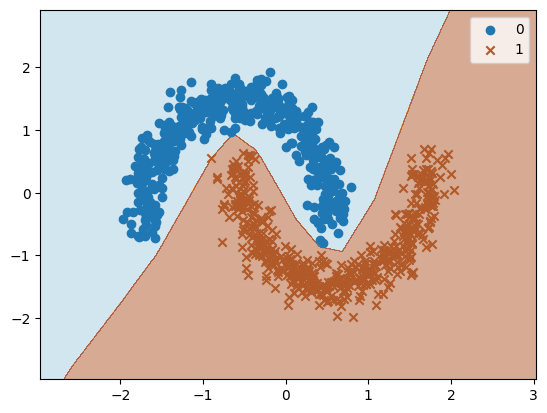

In [124]:
import numpy as np
import torch
import sklearn.datasets
from utils.visualization.visualize import plot_decision_boundary

def grad_to_list(model) -> np.array:
    trainable_parameters = np.array([])
    for param in model.parameters():
        trainable_parameters = np.append(trainable_parameters, param.grad.flatten().numpy())
    
    return trainable_parameters

X, y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=42)
X = (X - X.mean(axis=0)) / X.std(axis=0)

model = MLP(2, [10, 10], 1, use_batch_norm=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
criterion = torch.nn.BCELoss()

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

grads = []
model.train()
for epoch in range(60):
    optimizer.zero_grad()
    y_pred = model(X_tensor).flatten()
    loss = criterion(y_pred, y_tensor)
    loss.backward()
    grads.append(grad_to_list(model))
    optimizer.step()

plot_decision_boundary(model, X, y)



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


grad_0,▁▂▂▁▅▇▇▆▂▅█▇▃▁▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_1,▁▅██▆▄▁▃▅▆▆▅▃▃▁▁▁▁▁▂▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_10,▃▃▄▃▃▅▇▆▂▅█▇▃▁▃▃▁▂▃▂▁▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁
grad_100,█▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_101,█▁▂▃▂▂▂▄▇▇█▆▅▄▃▂▃▃▃▃▂▃▃▃▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁
grad_102,▁▁▁▂▅▇█▇▂▂▁▁▁▁▁▁▄▅▅▃▂▁▂▁▁▂▂▁▂▂▂▁▂▂▁▁▁▁▁▁
grad_103,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_104,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_105,▅▇█▇▃▁▃▃▃▃▃▃▁▁▂▂▃▄▃▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_106,█▂▂▂▁▂▄▄▅▆▆▄▂▁▁▁▃▃▂▁▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁
grad_107,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


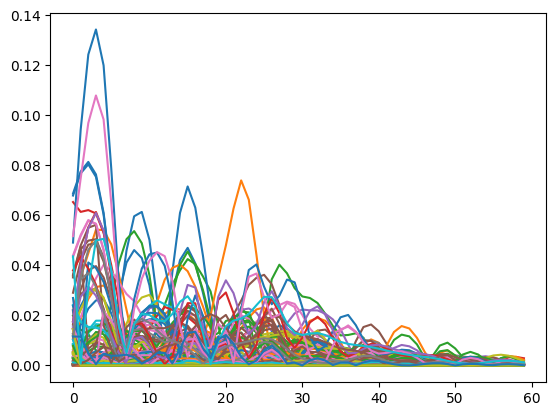

In [130]:
import matplotlib.pyplot as plt
import wandb

grads = np.abs(grads)

wandb.init(project="master-thesis", entity="idavron-team", name="important_weights")
for i in range(60):
    for j in range(151):
        wandb.log({f"grad_{j}": grads[i][j]})

wandb.finish()

plt.plot(grads)

In [154]:
threshold = 0.08
mask = grads.max(axis=0) > threshold
counter = mask.sum()

print(counter)
print(mask)

4
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False  True False False False False]
